# MVP: *Machine Learning & Analytics*

**Autor:** _Mauro Athayde Campos Nascimento_  

**Data:** 28/09/2025

**Dataset:** Suicide Rates Overview 1985 to 2016
(https://www.kaggle.com/datasets/russellyates88/suicide-rates-overview-1985-to-2016)

---



# 1. Escopo, objetivo e definição do problema

O suicídio é reconhecido como um grave problema de saúde pública, com impactos sociais e econômicos significativos. A literatura aponta que fatores como sexo, idade, condição econômica e diferenças regionais influenciam diretamente as taxas de suicídio, mas há divergências sobre o peso relativo de cada um desses determinantes.

**Nesse contexto, este trabalho busca responder à seguinte questão central: quais fatores explicam mais a taxa de suicídios por 100 mil habitantes — idade, sexo, condição econômica (PIB per capita) ou região do mundo?**

O objetivo do MVP é aplicar técnicas de aprendizado de máquina supervisionado, utilizando modelos de regressão em dados tabulares, para estimar a taxa de suicídios e, sobretudo, avaliar a importância relativa desses fatores. A análise é conduzida em duas etapas complementares:

Global: avaliando todos os países da base, de modo a identificar o padrão mundial.

Nacional: repetindo o procedimento apenas para o Brasil e comparando-o com Japão e Rússia, países de relevância histórica no tema, para verificar se o Brasil segue ou se afasta das tendências globais.

## 1.1 Hipóteses centrais do estudo:

#### 1.1.1 - Fatores demográficos — especialmente sexo masculino e faixas etárias mais avançadas — apresentam maior poder explicativo sobre as taxas de suicídio do que variáveis econômicas.

#### 1.1.2 - O Brasil tende a seguir o padrão global, ainda que em níveis absolutos mais baixos.

## 1.2 Dataset utilizado

**O dataset contém 27.820 observações, cobrindo o período de 1985 a 2016 em 101 países. A base foi originalmente disponibilizada no Kaggle (https://www.kaggle.com/datasets/UCImachinelearning/suicide-rates-overview-1985-to-2016
), e cada linha corresponde a um grupo definido por país, ano, sexo e faixa etária. A escolha desse dataset se justifica pela completude das informações demográficas e econômicas e pela relevância social do tema.**

O estudo reconhece limitações, como possíveis diferenças metodológicas na coleta entre países e o risco de interpretações indevidas em nível individual. Ainda assim, a análise em nível agregado permite extrair padrões relevantes para políticas públicas e para a compreensão dos determinantes do suicídio em escala global e nacional.

## 1.3 Valor e aplicação prática

O valor deste trabalho está em oferecer evidências quantitativas que auxiliem tanto a comunidade científica quanto gestores públicos e formuladores de políticas de saúde na priorização de recursos. Ao identificar os fatores mais relevantes na explicação das taxas de suicídio, o estudo pode apoiar estratégias de prevenção direcionadas a grupos mais vulneráveis, além de fornecer subsídios para comparações entre o Brasil e o padrão global.

Do ponto de vista metodológico, a entrega adota um pipeline reproduzível em ambiente aberto (Google Colab), o que agrega valor educacional e garante que a análise possa ser replicada, auditada ou atualizada com novos dados.

## 2. Reprodutibilidade e ambiente

- **Ambiente de execução:** Google Colab (Python 3.10).  
- **Bibliotecas principais utilizadas:**  
  - `pandas`, `numpy`: manipulação e análise de dados tabulares  
  - `matplotlib`: visualização de dados  
  - `scikit-learn`: pré-processamento (OneHotEncoder, StandardScaler, SimpleImputer, ColumnTransformer), modelagem e métricas de avaliação

Para garantir reprodutibilidade, definimos seeds fixas. Isso significa que, mesmo em algoritmos que envolvem aleatoriedade (como a divisão treino/teste ou modelos de aprendizado baseados em amostragem), os resultados se manterão consistentes a cada execução.


In [1]:
# Setup de reprodutibilidade e bibliotecas
import os, random, sys, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Definição de seed fixa para reprodutibilidade
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("✅ Ambiente configurado com seed fixa =", SEED)



✅ Ambiente configurado com seed fixa = 42



# 3. Dados: carga, entendimento e qualidade

**Antes da modelagem, realizamos uma exploração preliminar para entender a estrutura, a qualidade e a distribuição dos dados.**

O dataset utilizado é público, originalmente disponível no Kaggle, e foi hospedado no GitHub para permitir reprodutibilidade no Google Colab. Ele contém 27.820 observações, cobrindo o período de 1985 a 2016 em 101 países. Cada linha corresponde a um grupo definido por país, ano, sexo e faixa etária, contendo também informações demográficas e econômicas.

## 3.1 Dicionário resumido de variáveis principais:

`country`: país da observação.

`year`: ano da observação.

`sex`: sexo (male/female).

`age`: faixa etária (5–14, 15–24, …, 75+).

`suicides_no`: número absoluto de suicídios.

`population`: população correspondente ao grupo.

`suicides/100k pop`: taxa de suicídios padronizada por 100 mil habitantes.

`HDI for year`: índice de desenvolvimento humano (quando disponível).

`gdp_for_year ($)`: PIB total do país no ano (valores nominais).

`gdp_per_capita ($)`: PIB per capita.

`generation`: classificação geracional (GI Generation, Silent, Boomers, etc.).

`country-year`: identificador auxiliar, criado pela junção de país e ano; usado apenas como chave técnica para diferenciar registros, não empregado nos modelos preditivos.

Nas etapas abaixo, foram realizadas:

- Correções de tipagem (numéricas e categóricas).

- Tratamento de colunas numéricas (remoção de símbolos, pontos e espaços).

- Verificação de valores ausentes (identificação de variáveis com gaps, como o HDI).

- Estatísticas descritivas (média, desvio-padrão, mediana, mínimo e máximo).

**Importante**: nesta fase não há risco de vazamento de dados, pois as análises são apenas exploratórias. Essa exploração serve para identificar padrões iniciais e limitações que podem impactar as decisões de pipeline.


In [2]:
# =================== Setup Global ===================
import pandas as pd
import numpy as np

# Configuração global: separador de milhar = ',', decimal = '.'
pd.options.display.float_format = lambda x: f"{x:,.2f}"

# Função auxiliar para converter números sem destruir decimais
def to_number(series, as_int=False):
    s = (series.astype(str)
                .str.strip()                           # remove espaços extras
                .str.replace(r"[^0-9\.,]", "", regex=True))  # mantém números, vírgula e ponto

    # remove separador de milhar (,) e garante decimal ponto (.)
    s = s.str.replace(",", "")

    out = pd.to_numeric(s, errors="coerce")

    if as_int:
        return out.round().astype("Int64")
    return out

# =================== Importa ===================
url = "https://raw.githubusercontent.com/maurinhopa/MVPSuicideRate/refs/heads/main/Suicidal_Rates_1986-2016_New"
df = pd.read_csv(url, sep=";")

# =================== Limpeza / Tipagem ===================
# Converte colunas numéricas
df["suicides_no"]        = to_number(df["suicides_no"], as_int=True)
df["population"]         = to_number(df["population"], as_int=True)
df["suicides/100k pop"]  = to_number(df["suicides/100k pop"])
df["HDI for year"]       = to_number(df["HDI for year"])
df["gdp_for_year ($)"]   = to_number(df["gdp_for_year ($)"])
df["gdp_per_capita ($)"] = to_number(df["gdp_per_capita ($)"])

# Ajusta colunas categóricas
for c in ["country", "sex", "age", "country-year", "generation", "year"]:
    df[c] = df[c].astype("category")



## 3.2 Primeiras 10 linhas da base de dados
As primeiras linhas confirmam a estrutura da base, trazendo país, ano, sexo, faixa etária, suicídios absolutos, população, taxa padronizada, variáveis econômicas e geração, sem inconsistências aparentes.

In [3]:
display(df.head(10))


,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,2156624900,796.00,Generation X
1,Albania,1987,female,25-34 years,4,257200,1.56,Albania1987,NaN,2156624900,796.00,Boomers
2,Albania,1987,female,35-54 years,6,278800,2.15,Albania1987,NaN,2156624900,796.00,Silent
3,Albania,1987,female,5-14 years,0,311000,0.00,Albania1987,NaN,2156624900,796.00,Generation X
4,Albania,1987,female,55-74 years,0,144600,0.00,Albania1987,NaN,2156624900,796.00,G.I. Generation
5,Albania,1987,female,75+ years,1,35600,2.81,Albania1987,NaN,2156624900,796.00,G.I. Generation
6,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,2156624900,796.00,Generation X
7,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,2156624900,796.00,Boomers
8,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,2156624900,796.00,Silent
9,Albania,1987,male,5-14 years,0,338200,0.00,Albania1987,NaN,2156624900,796.00,Generation X


## 3.3 Número de instâncias e atributos
A base possui 27.820 registros e 12 atributos, cobrindo 31 anos em 101 países, o que garante volume adequado de dados para análise.

In [4]:
display(pd.DataFrame(
    {"Valor": [df.shape[0], df.shape[1]]},
    index=["Número de instâncias", "Número de atributos"]
))


,Valor
Número de instâncias,27820
Número de atributos,12


## 3.4 Tipos de dados
As variáveis foram convertidas corretamente: numéricas em formatos inteiros ou decimais e categóricas, assegurando compatibilidade com os pipelines de modelagem.

In [5]:
display(df.dtypes.astype(str).rename("dtype").to_frame())


,dtype
country,category
year,category
sex,category
age,category
suicides_no,Int64
population,Int64
suicides/100k pop,float64
country-year,category
HDI for year,float64
gdp_for_year ($),int64


## 3.5 Valores ausentes por coluna
A única variável com grande volume de nulos é o HDI for year (19.456 registros, cerca de 70%), enquanto todas as demais colunas estão completas.

In [6]:
display(df.isna().sum().sort_values(ascending=False).rename("nulos").to_frame())


,nulos
HDI for year,19456
country,0
sex,0
year,0
age,0
suicides_no,0
suicides/100k pop,0
population,0
country-year,0
gdp_for_year ($),0


## 3.6 Resumo estatístico (numéricos)
O resumo estatístico **mostra a forte heterogeneidade da base**. Os suicídios variam de **0 a mais de 22 mil casos por grupo**, enquanto a população dos recortes vai de apenas **278 habitantes a mais de 43 milhões**, o que gera taxas extremas como o máximo de 224,97/100k (casos em populações muito pequenas, que não comporta bem a métrica de 100 mil por caso). A mediana da taxa é de 6/100k, mas a média sobe para 12,8/100k devido a poucos valores muito altos, confirmando uma distribuição assimétrica com cauda longa. **Já o PIB per capita varia de menos de USD 300 até mais de USD 126 mil**, reforçando a grande diversidade socioeconômica. Em síntese, a base reúne populações díspares, taxas desiguais e forte variação econômica, fatores que exigem cuidado com outliers, mas também **ampliam o potencial analítico do estudo**.

In [7]:
desc = df.select_dtypes("number").describe().T
desc["mean"] = desc["mean"].map(lambda x: f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
desc["std"] = desc["std"].map(lambda x: f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
display(desc)


,count,mean,std,min,25%,50%,75%,max
suicides_no,"27,820.00","242,57","902,05",0.00,3.00,25.00,131.00,"22,338.00"
population,"27,820.00","1.844.793,62","3.911.779,44",278.00,"97,498.50","430,150.00","1,486,143.25","43,805,214.00"
suicides/100k pop,"27,820.00","12,82","18,96",0.00,0.92,5.99,16.62,224.97
HDI for year,"8,364.00","0,78","0,09",0.48,0.71,0.78,0.85,0.94
gdp_for_year ($),"27,820.00","445.580.969.025,73","1.453.609.985.940,92","46,919,625.00","8,985,352,832.00","48,114,688,201.00","260,202,429,150.00","18,120,714,000,000.00"
gdp_per_capita ($),"27,820.00","16.866,46","18.887,58",251.00,"3,447.00","9,372.00","24,874.00","126,352.00"


## 3.7 Medianas (numéricos)
As medianas reforçam o padrão de grupos relativamente pequenos (≈430 mil habitantes), PIB per capita mediano de 9.372 USD e HDI em torno de 0,78, valores representativos do conjunto global.

In [8]:
med = df.select_dtypes("number").median().round(2).to_frame("mediana")
med["mediana"] = med["mediana"].map(lambda x: f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
display(med)

,mediana
suicides_no,"25,00"
population,"430.150,00"
suicides/100k pop,"5,99"
HDI for year,"0,78"
gdp_for_year ($),"48.114.688.201,00"
gdp_per_capita ($),"9.372,00"


# Etapa 4 — EDA (Exploratory Data Analysis)

A análise exploratória busca entender o comportamento da base antes da modelagem, por meio de estatísticas descritivas e visualizações. Nesta etapa investigamos distribuições, correlações, comparações entre grupos e outliers, de forma a identificar padrões relevantes sobre os fatores associados às taxas de suicídio.

## 4.1 Evolução da Taxa Global de Suicídio - 1985 - 2016 (Por 100 mil habitantes)

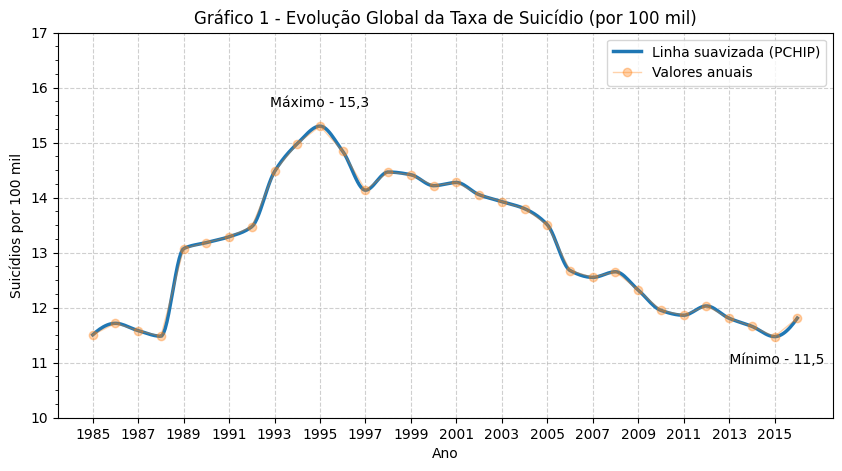

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy.interpolate import PchipInterpolator  # spline que preserva a forma (sem overshoot)

# Se "ts" não existir, recalcula a série agregada correta (∑suicides / ∑pop × 100k)
if "ts" not in locals():
    df_ok = df.dropna(subset=["suicides_no","population"]).copy()
    df_ok["year_int"] = df_ok["year"].astype(int)
    ts = (
        df_ok.groupby("year_int", as_index=False)
             .agg(suicides_no=("suicides_no","sum"),
                  population=("population","sum"))
             .assign(rate_100k=lambda d: (d["suicides_no"]/d["population"]) * 100000)
             .sort_values("year_int")
    )

# ------- linha suavizada sem média móvel -------
x = ts["year_int"].to_numpy()
y = ts["rate_100k"].to_numpy()

# spline PCHIP (passa pelos pontos, sem “ondas” artificiais)
pchip = PchipInterpolator(x, y)
x_smooth = np.linspace(x.min(), x.max(), 400)
y_smooth = pchip(x_smooth)

# ------- escala (bandas) mais justa -------
pad = (y.max() - y.min()) * 0.06   # ~6% de folga

plt.figure(figsize=(10,5))
plt.plot(x_smooth, y_smooth, linewidth=2.5, label="Linha suavizada (PCHIP)")
plt.plot(x, y, marker="o", linewidth=1, alpha=0.35, label="Valores anuais")  # opcional: pontos reais

plt.title("Gráfico 1 - Evolução Global da Taxa de Suicídio (por 100 mil)")
plt.xlabel("Ano")
plt.ylabel("Suicídios por 100 mil")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

ax = plt.gca()
ax.set_ylim(y.min() - pad, y.max() + pad)   # “bandas” mais próximas do dado
ax.xaxis.set_ticks(np.arange(x.min(), x.max()+1, 2))  # ticks a cada 2 anos
ax.yaxis.set_major_locator(MultipleLocator(0.5))      # passo de 0,5
ax.yaxis.set_minor_locator(MultipleLocator(0.5))     # grade fina

from matplotlib.ticker import MultipleLocator

ax = plt.gca()
ax.set_ylim(10, 17)                      # fixa a escala do eixo Y entre 10 e 17
ax.yaxis.set_major_locator(MultipleLocator(1.0))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))

# anotações: pico e mínimo (só o número, sem seta)
peak_i = np.argmax(y)
min_i  = np.argmin(y)

# offsets verticais (ajuste se quiser)
off_up = 0.30
off_dn = 0.30

ax.text(x[peak_i], y[peak_i] + off_up,
        f"Máximo - {y[peak_i]:.1f}".replace(".", ","),  # vírgula decimal
        ha="center", va="bottom", fontsize=10)

ax.text(x[min_i], y[min_i] - off_dn,
        f" Mínimo - {y[min_i]:.1f}".replace(".", ","),  # vírgula decimal
        ha="center", va="top", fontsize=10)


plt.show()




**Análise do Gráfico: Evolução Global da Taxa de Suicídio (1985–2016)**
Entre 1986 e 2016, a taxa global por 100 mil habitantes descreve uma única onda: sobe do fim dos anos 1980 até atingir o pico em 1995; depois entra em queda contínua até o início dos anos 2010 e, a partir daí, mantém-se estável em patamar mais baixo até o final da série.

Com o eixo fixado entre 10 e 17, a variação aparece como moderada, sem saltos abruptos. A linha suavizada apenas melhora a leitura visual, sem alterar os valores anuais.

- **Pico**: meados dos anos 1990 — ponto mais alto da série (15,3 por 100 mil).

- **Mínimo**: início dos anos 2010 — ponto mais baixo (11,5 por 100 mil).

- **Amplitude**: diferença de alguns pontos por 100 mil entre pico e mínimo, sem rupturas bruscas.

- **Encerramento**: o final do período permanece abaixo do pico, sem reversão clara da tendência.



No intuito de aprofundar a análise e entender quais grupos de países mais contribuíram para essa variação, a próxima etapa será complementar a visão global com comparações específicas entre sexos, idades e regiões.

### 4.1.1 Evolução da Taxa Global de Suicídio - 1985 - 2016 (Por 100 mil habitantes) por Região

Total países na base: 101
Total países mapeados: 101
Diferença: set()


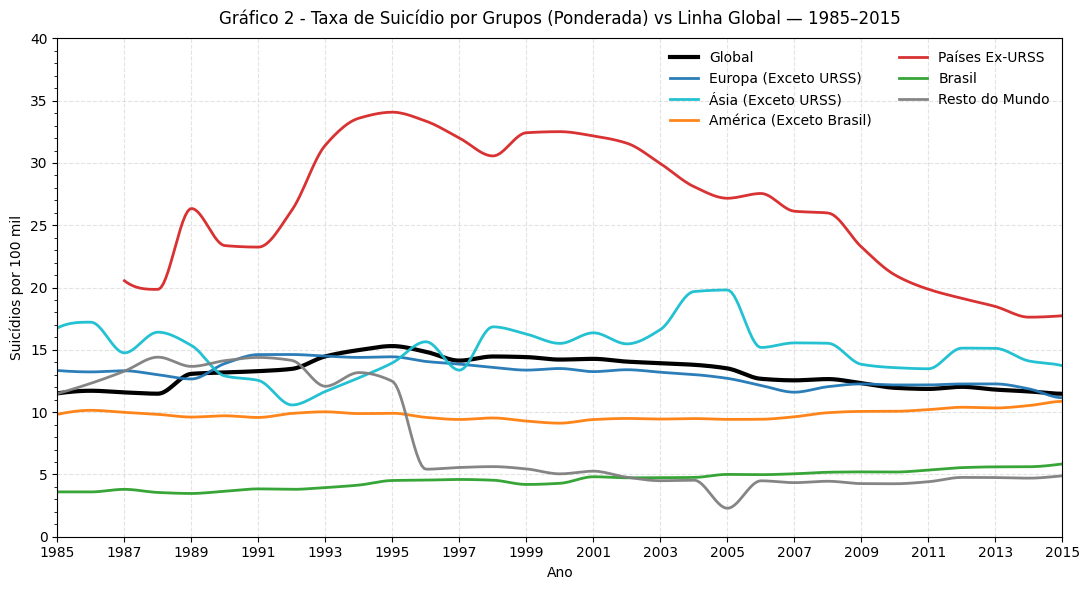

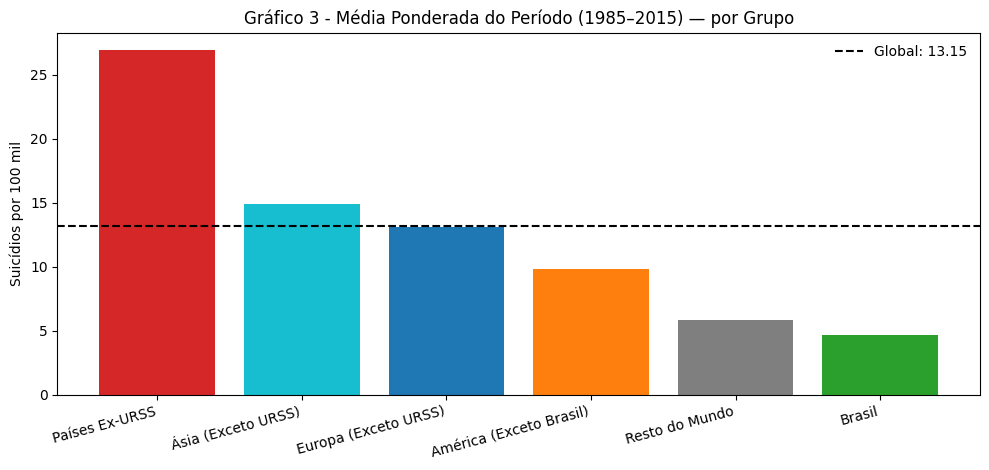

In [10]:
# ======================
# CLASSIFICAÇÃO + GRÁFICOS
# ======================

from scipy.interpolate import PchipInterpolator
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import numpy as np

# --- 1) Grupos fixos (101 países)
ex_urss = [
    "Armenia","Azerbaijan","Belarus","Estonia","Georgia","Kazakhstan",
    "Kyrgyzstan","Latvia","Lithuania","Russian Federation","Turkmenistan",
    "Ukraine","Uzbekistan"
]

asia_exc_urss = [
    "Japan","Mongolia","Philippines","Republic of Korea","Singapore",
    "Sri Lanka","Thailand","Turkey","Israel","Maldives","Oman"
]

europa_exc_urss = [
    "Albania","Austria","Belgium","Bosnia and Herzegovina","Bulgaria",
    "Croatia","Cyprus","Czech Republic","Denmark","Finland","France",
    "Germany","Greece","Hungary","Iceland","Ireland","Italy",
    "Luxembourg","Malta","Montenegro","Netherlands","Norway","Poland",
    "Portugal","Romania","San Marino","Serbia","Slovakia","Slovenia",
    "Spain","Sweden","Switzerland","United Kingdom"
]

america_exc_brasil = [
    "Antigua and Barbuda","Argentina","Aruba","Bahamas","Barbados",
    "Belize","Canada","Chile","Colombia","Costa Rica","Cuba","Dominica",
    "Ecuador","El Salvador","Grenada","Guatemala","Jamaica","Mexico",
    "Nicaragua","Panama","Paraguay","Puerto Rico","Saint Kitts and Nevis",
    "Saint Lucia","Saint Vincent and Grenadines","Suriname",
    "Trinidad and Tobago","United States","Uruguay","Guyana"
]

brasil = ["Brazil"]

resto_do_mundo = [
    "Australia","Bahrain","Cabo Verde","Fiji","Kiribati","Kuwait",
    "Macau","Mauritius","New Zealand","Qatar","Seychelles",
    "South Africa","United Arab Emirates"
]

# --- 2) Classificação
def classify_region(country):
    if country in ex_urss:
        return "Países Ex-URSS"
    elif country in asia_exc_urss:
        return "Ásia (Exceto URSS)"
    elif country in europa_exc_urss:
        return "Europa (Exceto URSS)"
    elif country in america_exc_brasil:
        return "América (Exceto Brasil)"
    elif country in brasil:
        return "Brasil"
    elif country in resto_do_mundo:
        return "Resto do Mundo"
    else:
        return "ERRO — país não mapeado!"

df_ok["region"] = df_ok["country"].apply(classify_region)

# --- 3) Checagem
todos = set(df_ok["country"].unique())
mapeados = set(ex_urss + asia_exc_urss + europa_exc_urss + america_exc_brasil + brasil + resto_do_mundo)
print("Total países na base:", len(todos))
print("Total países mapeados:", len(mapeados))
print("Diferença:", todos - mapeados)

# --- 4) Séries temporais
reg_ts = (
    df_ok.groupby(["region","year_int"], as_index=False)
         .agg(suicides_no=("suicides_no","sum"),
              population=("population","sum"))
         .assign(rate_100k=lambda d: d["suicides_no"]/d["population"]*100000)
)

ts_global = (
    df_ok.groupby("year_int", as_index=False)
         .agg(suicides_no=("suicides_no","sum"),
              population=("population","sum"))
         .assign(rate_100k=lambda d: d["suicides_no"]/d["population"]*100000)
)

# --- 5) Função suavizadora
def smooth_xy(x, y, n=400):
    p = PchipInterpolator(x, y)
    xs = np.linspace(x.min(), x.max(), n)
    ys = p(xs)
    return xs, ys

# --- 6) Ordem + cores
order = [
    "Europa (Exceto URSS)",
    "Ásia (Exceto URSS)",
    "América (Exceto Brasil)",
    "Países Ex-URSS",
    "Brasil",
    "Resto do Mundo",
]

palette = {
    "Europa (Exceto URSS)":     "#1f77b4",
    "Ásia (Exceto URSS)":       "#17becf",
    "América (Exceto Brasil)":  "#ff7f0e",
    "Países Ex-URSS":           "#d62728",
    "Brasil":                   "#2ca02c",
    "Resto do Mundo":           "#7f7f7f",
}

# --- 7) Gráfico 1: evolução temporal
fig, ax = plt.subplots(figsize=(11,6))

# Global
xg = ts_global["year_int"].to_numpy()
yg = ts_global["rate_100k"].to_numpy()
xg_s, yg_s = smooth_xy(xg, yg, n=500)
ax.plot(xg_s, yg_s, color="black", linewidth=3, label="Global")

# Regiões
for region in order:
    s = reg_ts[reg_ts["region"] == region]
    if s.empty or s["year_int"].nunique() < 2:
        continue
    xr = s["year_int"].to_numpy()
    yr = s["rate_100k"].to_numpy()
    xs, ys = smooth_xy(xr, yr, n=400)
    ax.plot(xs, ys, linewidth=2, alpha=0.95, color=palette[region], label=region)

ax.set_title("Gráfico 2 - Taxa de Suicídio por Grupos (Ponderada) vs Linha Global — 1985–2015", pad=10)
ax.set_xlabel("Ano")
ax.set_ylabel("Suicídios por 100 mil")
ax.set_xlim(1985, 2015)
ax.set_ylim(0, 40)
ax.xaxis.set_ticks(np.arange(1985, 2016, 2))
ax.yaxis.set_major_locator(MultipleLocator(5.0))
ax.yaxis.set_minor_locator(MultipleLocator(1.0))
ax.grid(True, linestyle="--", alpha=0.35)
ax.legend(ncol=2, frameon=False)
fig.tight_layout()
plt.show()

# --- 8) Gráfico 2: médias do período
means = (
    df_ok.groupby("region", as_index=False)
         .agg(suicides_no=("suicides_no","sum"), population=("population","sum"))
         .assign(rate_mean_100k=lambda d: (d["suicides_no"]/d["population"])*100000)
)

means_plot = (
    means.set_index("region")
         .reindex(order)
         .reset_index()[["region","rate_mean_100k"]]
)

global_mean_rate = float((df_ok["suicides_no"].sum() / df_ok["population"].sum()) * 100000)

# --- Ordena pelo valor da média (decrescente)
means_plot_sorted = means_plot.sort_values(by="rate_mean_100k", ascending=False)

plt.figure(figsize=(10,4.8))
colors = [palette[r] for r in means_plot_sorted["region"]]
plt.bar(means_plot_sorted["region"], means_plot_sorted["rate_mean_100k"], color=colors)
plt.axhline(global_mean_rate, linestyle="--", linewidth=1.5, color="black",
            label=f"Global: {global_mean_rate:.2f}")
plt.title("Gráfico 3 - Média Ponderada do Período (1985–2015) — por Grupo")
plt.ylabel("Suicídios por 100 mil")
plt.xticks(rotation=15, ha="right")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# --- 9) Limpa se não for mais usar
df_ok = df_ok.drop(columns=["region"])


**Análise sobre a evolução temporal por grupo**

Entre 1985 e 2015, a linha global (preta) descreve uma trajetória em “onda”: subida até meados dos anos 1990 (aprox. 15/100k), seguida de queda contínua até o início dos anos 2010 (aprox. 11–12/100k), estabilizando depois disso.

**Os grupos se posicionam da seguinte forma:**

**Países Ex-URSS (vermelho)**
Nível disparado acima dos demais. Pico superior a 30/100k na década de 1990, relacionado ao colapso político e socioeconômico pós-soviético. Depois, declínio gradual, mas ainda encerrando acima da média global (~20/100k). Principal responsável por puxar o topo global dos anos 90.

**Ásia (Exceto URSS) (ciano)**
Oscila em torno da linha global, com picos pontuais nos anos 2000 (~20/100k). Termina o período próximo a 13–14/100k, levemente acima da média global.

**Europa (Exceto URSS) (azul)**
Trajetória mais estável. Permanece entre 12–14/100k durante quase todo o período, com leve declínio após 2000. Fica próxima, mas ligeiramente abaixo da global no final.

**América (Exceto Brasil) (laranja)**
Sempre abaixo da global, variando em torno de 9–11/100k. Leve tendência de alta no fim do período.

**Brasil (verde)**
Nível consistentemente mais baixo do painel (~3–6/100k), com leve tendência de alta após 2000. É o grupo que mais reduz o nível agregado.

**Resto do Mundo (cinza)**
Posição intermediária: começa próximo da global no fim dos anos 80/início dos 90, mas segue trajetória de queda, terminando entre 5–6/100k. Apesar da heterogeneidade, o grupo reforça o padrão de redução.

De forma análoga, o gráfico 4.3 reforça as diferenças estruturais entre os grupos:

**Países Ex-URSS (~27/100k)** — valor mais alto, mais que o dobro da média global (13,15).

**Ásia (Exceto URSS) (~15/100k)** — ligeiramente acima da global.

**Europa (Exceto URSS) (~13/100k)** — alinhada à global, orbitando próximo à média.

**América (Exceto Brasil) (~10/100k)** — abaixo da global, mas ainda com relevância demográfica.

**Resto do Mundo (~6/100k)** — baixo, reforça a tendência de queda.

**Brasil (~4–5/100k)** — nível mais baixo de todos os grupos.

Dessa forma, a análise das médias ponderadas deixa claro que a trajetória global das taxas de suicídio não é homogênea, mas fortemente influenciada por diferenças regionais.

O formato da curva mundial foi ditado principalmente pelos países Ex-URSS, que apresentaram níveis excepcionalmente altos após o colapso soviético, elevando a média global nos anos 1990.

Europa e Ásia orbitam em torno da linha global, mantendo relativa estabilidade e funcionando como forças de equilíbrio. Em contrapartida, América (exceto Brasil) e o grupo Resto do Mundo contribuíram para aliviar a média, situando-se de forma consistente abaixo da global, enquanto o Brasil se destacou como o grupo com os menores índices de todo o painel.

**Esse resultado reforça o peso da região funcionando como proxy de fatores culturais, sociais e políticos que moldam o comportamento suicida, quee se manifesta de forma evidente quando olhamos a decomposição regional do fenômeno.**

## 4.2 Análise Demográfica: Gênero e Faixa Etária — Global x Brasil
A seguir, aprofundamos a análise considerando características demográficas fundamentais — gênero e faixa etária — em um comparativo entre o cenário global e o Brasil. Esses recortes permitem observar como fatores estruturais da população influenciam as taxas de suicídio, funcionando como variáveis-chave para compreender o fenômeno. Ao analisar gênero e idade, buscamos identificar padrões consistentes e diferenças contextuais, que podem revelar tanto determinantes universais quanto especificidades do caso brasileiro.

/tmp/ipython-input-3625317195.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  suicidios_sexo_global = df.groupby("sex", as_index=False)["suicides_no"].sum()
/tmp/ipython-input-3625317195.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  suicidios_sexo_brasil = df_br.groupby("sex", as_index=False)["suicides_no"].sum()
/tmp/ipython-input-3625317195.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=suicidios_sexo_global, x="sex", y="suicides_no",
/

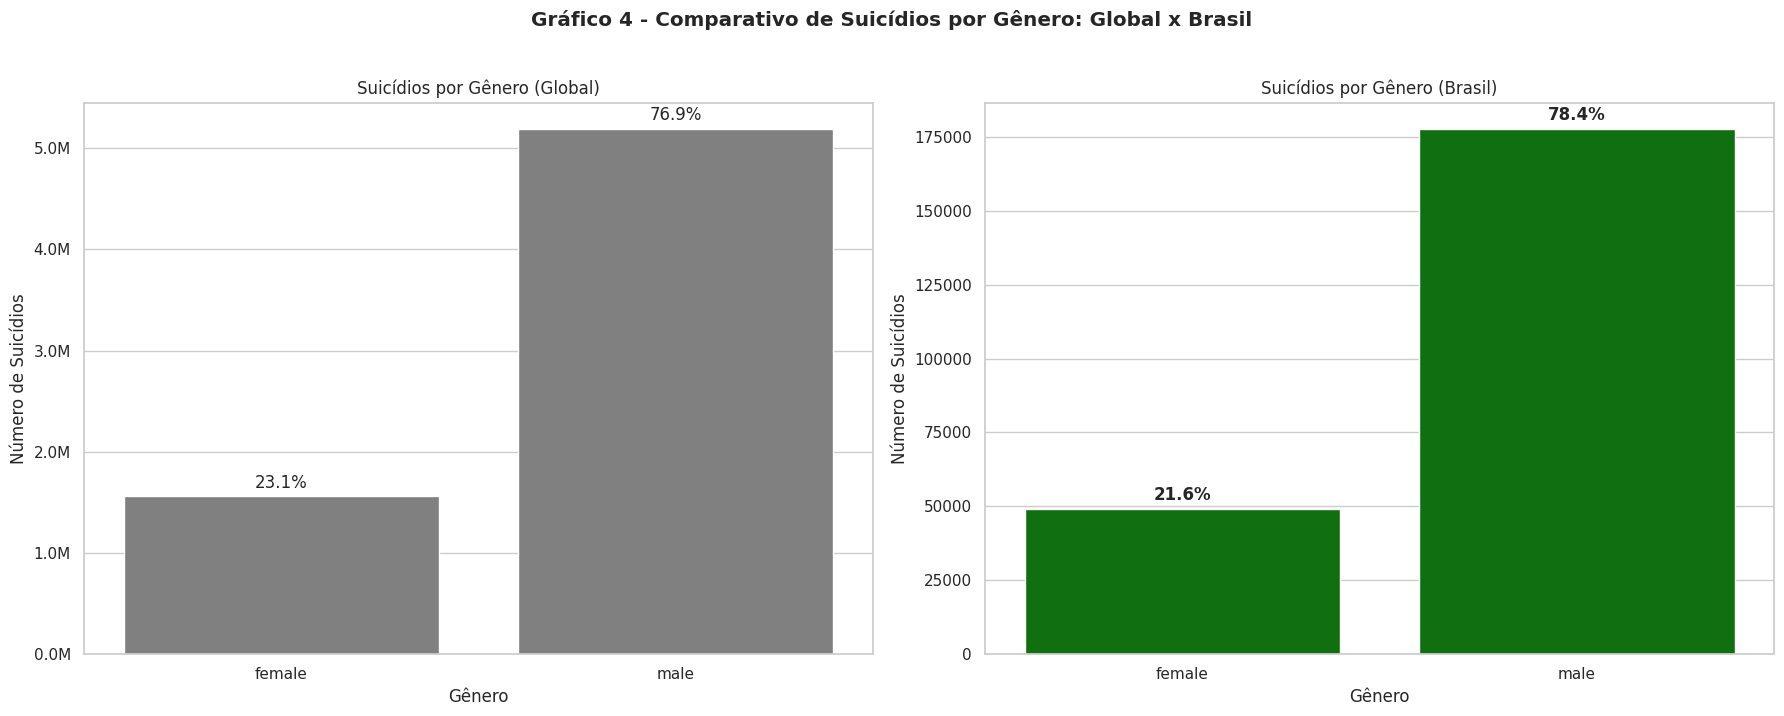

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configurações iniciais para um visual melhor
sns.set_theme(style="whitegrid", palette="pastel")
plt.rcParams['figure.figsize'] = (16, 8)  # Tamanho maior para os dois gráficos
plt.rcParams['font.size'] = 12

# Garante tipagem correta
df["suicides_no"] = pd.to_numeric(df["suicides_no"], errors="coerce")

# 1. Prepara os dados Globais
suicidios_sexo_global = df.groupby("sex", as_index=False)["suicides_no"].sum()
total_global = suicidios_sexo_global["suicides_no"].sum()

# 2. Prepara os dados do Brasil
df_br = df[df["country"] == "Brazil"].copy()
suicidios_sexo_brasil = df_br.groupby("sex", as_index=False)["suicides_no"].sum()
total_brasil = suicidios_sexo_brasil["suicides_no"].sum()

# Cria a figura e os dois subgráficos lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(18, 7))

# Gráfico da esquerda: Análise Global
sns.barplot(data=suicidios_sexo_global, x="sex", y="suicides_no",
            palette=["grey", "grey"], ax=ax1)
ax1.set_title("Suicídios por Gênero (Global)")
ax1.set_xlabel("Gênero", fontsize=12)
ax1.set_ylabel("Número de Suicídios", fontsize=12)

# Ajusta a escala do eixo Y para milhões
ax1.get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda y_tick, loc: f"{y_tick/1_000_000:.1f}M")
)

# Adiciona o percentual no gráfico Global
for p in ax1.patches:
    value = p.get_height()
    if total_global > 0 and not np.isnan(value):
        ax1.annotate(f"{(value / total_global) * 100:.1f}%",
                     (p.get_x() + p.get_width() / 2., value),
                     ha="center", va="center",
                     xytext=(0, 10),
                     textcoords="offset points", fontsize=12)

# Gráfico da direita: Análise Brasil
sns.barplot(data=suicidios_sexo_brasil, x="sex", y="suicides_no",
            palette=["green", "green"], ax=ax2)
ax2.set_title("Suicídios por Gênero (Brasil)")
ax2.set_xlabel("Gênero", fontsize=12)
ax2.set_ylabel("Número de Suicídios", fontsize=12)

# Adiciona o percentual no gráfico do Brasil
for p in ax2.patches:
    value = p.get_height()
    if total_brasil > 0 and not np.isnan(value):
        ax2.annotate(f"{(value / total_brasil) * 100:.1f}%",
                     (p.get_x() + p.get_width() / 2., value),
                     ha="center", va="center",
                     xytext=(0, 10),
                     textcoords="offset points", fontsize=12, fontweight="bold")

plt.suptitle("Gráfico 4 - Comparativo de Suicídios por Gênero: Global x Brasil",
             fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


**Análise — Gênero (Global x Brasil)**

A análise por gênero mostra que os **homens concentram a esmagadora maioria dos suicídios**, tanto no mundo (76,9%) quanto no Brasil (78,4%). As mulheres, por sua vez, representam apenas cerca de um quinto dos casos. Essa consistência revela que a variável sexo é um fator determinante, funcionando como proxy de questões culturais e comportamentais. A literatura demonstra que homens tendem a procurar menos ajuda em saúde mental e a serem mais impactados por pressões socioeconômicas e de papel social. **A proximidade dos percentuais global e brasileiro reforça que se trata de um padrão estrutural**, pouco influenciado por contexto regional.

/tmp/ipython-input-1411179702.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_geral = df.groupby("age", as_index=False)["suicides_no"].sum()
/tmp/ipython-input-1411179702.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_brasil_ordenado = df_brasil.groupby("age", as_index=False)["suicides_no"].sum()
/tmp/ipython-input-1411179702.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_geral_ordenado, x="age", y="suicides_no",
/tmp/ipython-inpu

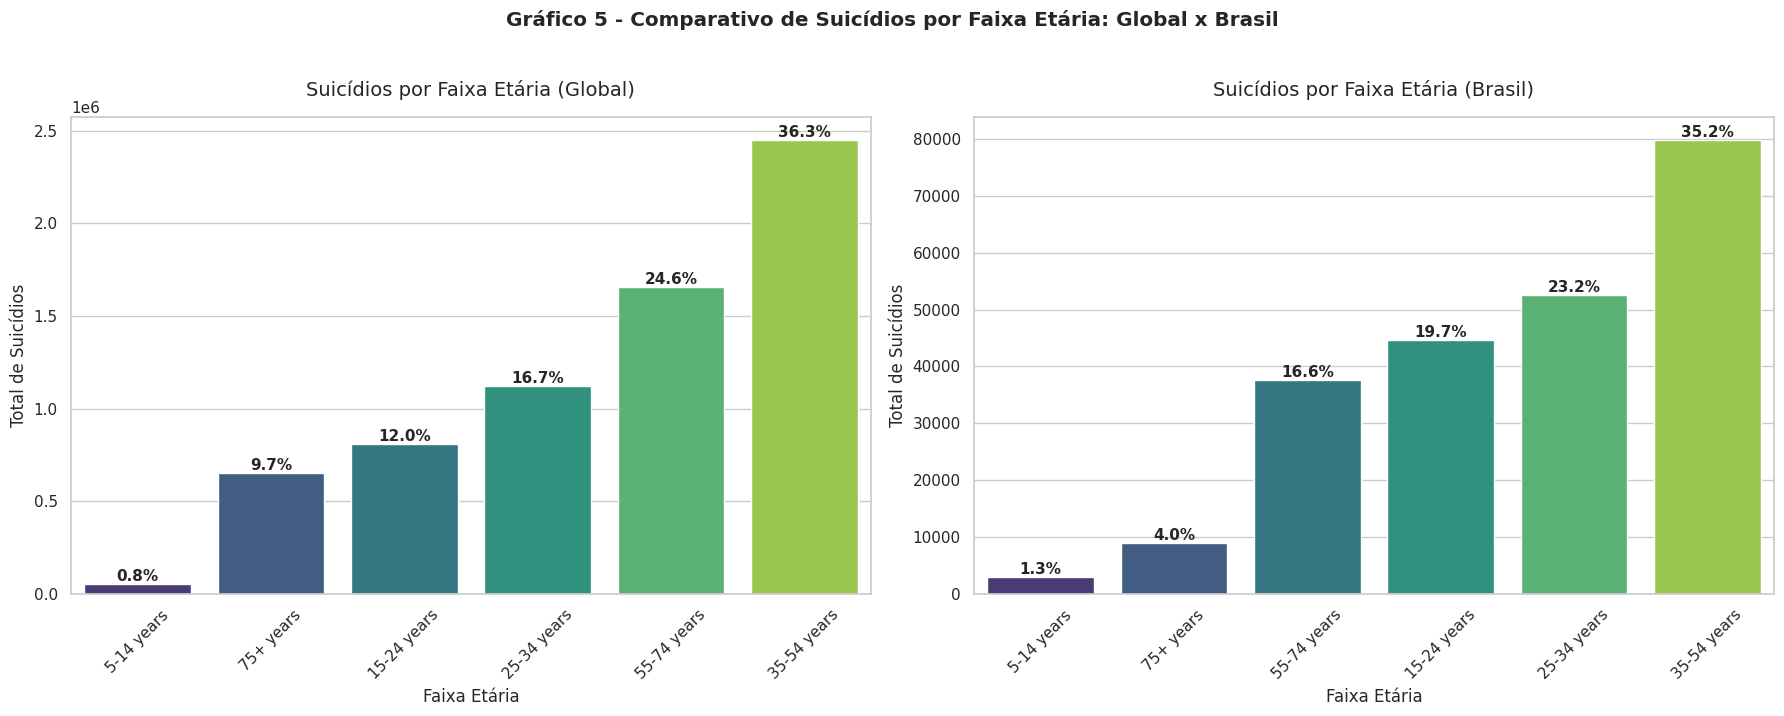

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- PREPARAÇÃO DOS DADOS ---
df["suicides_no"] = pd.to_numeric(df["suicides_no"], errors="coerce")

# Global
df_geral = df.groupby("age", as_index=False)["suicides_no"].sum()
df_geral_ordenado = df_geral.sort_values(by="suicides_no")
total_geral = df_geral_ordenado["suicides_no"].sum()

# Brasil
df_brasil = df[df["country"] == "Brazil"].copy()
df_brasil_ordenado = df_brasil.groupby("age", as_index=False)["suicides_no"].sum()
df_brasil_ordenado = df_brasil_ordenado.sort_values(by="suicides_no")
total_brasil = df_brasil_ordenado["suicides_no"].sum()

# --- CRIAÇÃO DOS GRÁFICOS LADO A LADO ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Gráfico Global
sns.barplot(data=df_geral_ordenado, x="age", y="suicides_no",
            palette="viridis", ax=ax1, order=df_geral_ordenado["age"])

# Adiciona os percentuais no gráfico Global
for p in ax1.patches:
    value = p.get_height()
    if total_geral > 0 and not np.isnan(value):
        percent = f"{(100 * value / total_geral):.1f}%"
        ax1.annotate(percent,
                     (p.get_x() + p.get_width() / 2, value),
                     ha="center", va="bottom",
                     fontsize=11, weight="bold")

ax1.set_title("Suicídios por Faixa Etária (Global)", fontsize=14, pad=15)
ax1.set_xlabel("Faixa Etária")
ax1.set_ylabel("Total de Suicídios")
ax1.tick_params(axis="x", rotation=45)

# Gráfico Brasil
sns.barplot(data=df_brasil_ordenado, x="age", y="suicides_no",
            palette="viridis", ax=ax2, order=df_brasil_ordenado["age"])

# Adiciona os percentuais no gráfico Brasil
for p in ax2.patches:
    value = p.get_height()
    if total_brasil > 0 and not np.isnan(value):
        percent = f"{(100 * value / total_brasil):.1f}%"
        ax2.annotate(percent,
                     (p.get_x() + p.get_width() / 2, value),
                     ha="center", va="bottom",
                     fontsize=11, weight="bold")

ax2.set_title("Suicídios por Faixa Etária (Brasil)", fontsize=14, pad=15)
ax2.set_xlabel("Faixa Etária")
ax2.set_ylabel("Total de Suicídios")
ax2.tick_params(axis="x", rotation=45)

plt.suptitle("Gráfico 5 - Comparativo de Suicídios por Faixa Etária: Global x Brasil",
             fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


**Análise — Faixa Etária (Global x Brasil)**

Tanto no Brasil quanto globalmente, os **adultos de 35–54** anos e os **idosos de 55–74 anos** concentram a maior parte dos suicídios, confirmando que o fenômeno se intensifica nas fases mais maduras da vida. As faixas mais jovens aparecem com participação menor, especialmente os **5–14 anos**, que ficam abaixo de 2% em ambos os cenários. A diferença mais marcante está no grupo **75+ anos**, que tem peso significativo no mundo (9,7%), mas reduzido no Brasil (4,0%), refletindo fatores demográficos e contextuais, como uma população brasileira mais jovem e menor expectativa de vida. Esses resultados reforçam que **a idade é uma variável crítica** para explicar taxas de suicídio, indicando a necessidade de priorizar políticas de prevenção voltadas para as faixas adultas e maduras, onde o impacto social e econômico é mais elevado.

## 4.3 Distribuição da Taxa de Suicídios (1985–2015)

Procedemos com a análise da distribuição de nossa variável algo, a qual apresenta um **forte viés à direita**, ou seja, a grande maioria dos casos concentra-se em níveis baixos, próximos de **0 a 20 suicídios por 100 mil habitantes**, intervalo que corresponde ao padrão esperado em bases internacionais, como relatórios da OMS, enquanto valores muito elevados aparecem como **outliers** pouco frequentes. O valor máximo registrado na base chega a **225/100k**, mas trata-se de casos excepcionais, conforme já mencionado, associados a **pequenas populações** onde poucas ocorrências já elevam drasticamente a taxa. Esse formato sugere que, embora existam situações extremas, o fenômeno globalmente se concentra em patamares moderados, com poucas ocorrências puxando a cauda longa da distribuição.

Valor máximo: 225.0
Valor mínimo: 0.0


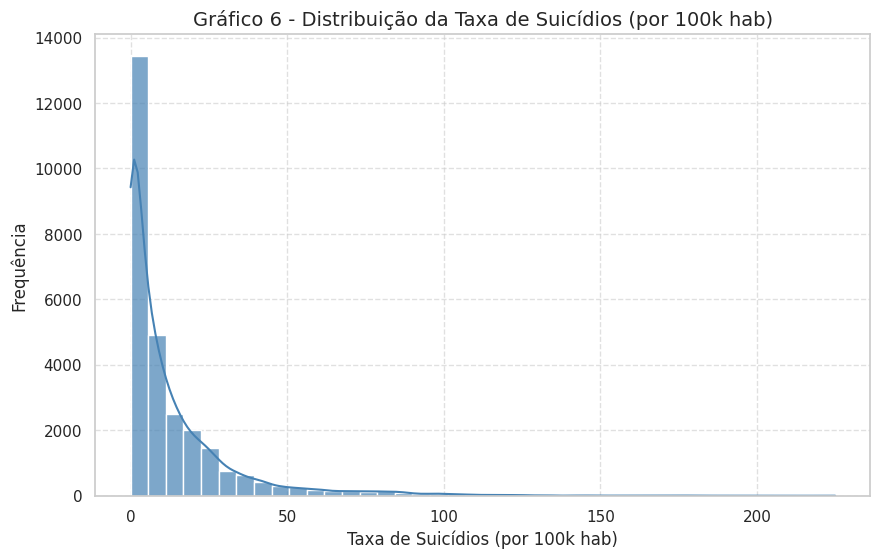

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Importa a base com separador correto
url = "https://raw.githubusercontent.com/maurinhopa/suicide_rate/refs/heads/main/Database_Suicide_Rate%201985-2016.csv"
df = pd.read_csv(url, sep=";", encoding="utf-8")

# 2. Padroniza nomes de colunas
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

# 3. Converte a coluna suicides/100k_pop (vírgula -> ponto)
df["suicides/100k_pop"] = (
    df["suicides/100k_pop"]
    .astype(str)
    .str.replace(",", ".", regex=False)
    .replace("nan", pd.NA)
    .astype(float)
)

# 4. Conferir os valores para validar
print("Valor máximo:", df["suicides/100k_pop"].max())
print("Valor mínimo:", df["suicides/100k_pop"].min())

# 5. Plotar histograma com curva KDE
plt.figure(figsize=(10,6))
sns.histplot(df["suicides/100k_pop"], bins=40, kde=True, color="steelblue", alpha=0.7)

plt.title("Gráfico 6 - Distribuição da Taxa de Suicídios (por 100k hab)", fontsize=14)
plt.xlabel("Taxa de Suicídios (por 100k hab)")
plt.ylabel("Frequência")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


## 4.4 Top 10 Países com Maior Taxa Média de Suicídios (1985–2015)

/tmp/ipython-input-2370449649.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top, y="country", x="suicides/100k_pop", palette="Reds_r")


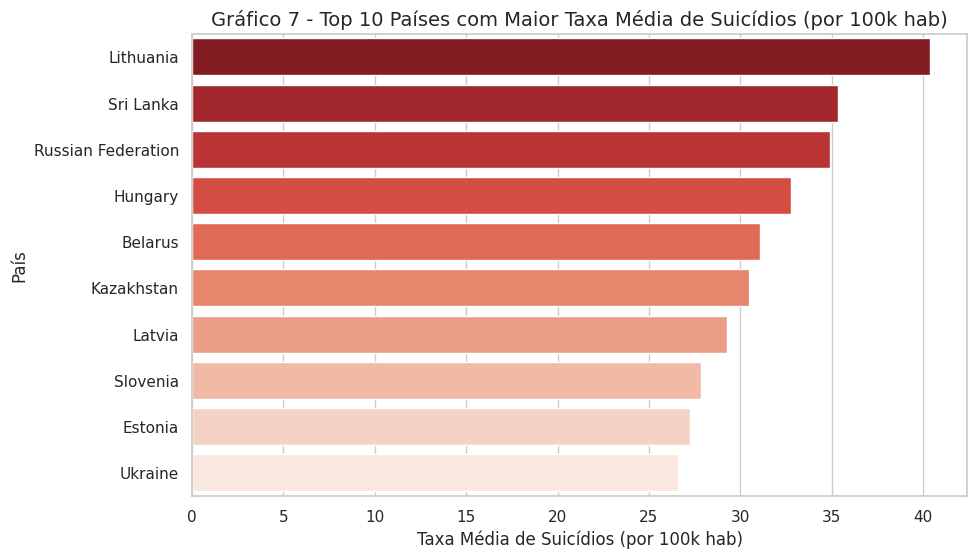

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Importar base
url = "https://raw.githubusercontent.com/maurinhopa/suicide_rate/refs/heads/main/Database_Suicide_Rate%201985-2016.csv"
df = pd.read_csv(url, sep=";", encoding="utf-8")

# 2. Padronizar colunas
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

# 3. Corrigir vírgula decimal
df["suicides/100k_pop"] = (
    df["suicides/100k_pop"]
    .astype(str)
    .str.replace(",", ".", regex=False)
    .replace("nan", pd.NA)
    .astype(float)
)

# 4. Calcular média por país
df_top = (
    df.groupby("country")["suicides/100k_pop"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# 5. Plotar gráfico de barras horizontais
plt.figure(figsize=(10,6))
sns.barplot(data=df_top, y="country", x="suicides/100k_pop", palette="Reds_r")

plt.title("Gráfico 7 - Top 10 Países com Maior Taxa Média de Suicídios (por 100k hab)", fontsize=14)
plt.xlabel("Taxa Média de Suicídios (por 100k hab)")
plt.ylabel("País")
plt.show()


O ranking mostra que **países da Europa Oriental e do antigo bloco soviético** dominam a lista das maiores taxas médias de suicídio, com destaque para **Lituânia, Rússia, Hungria, Belarus e Ucrânia**, todas acima de 30 casos por 100 mil habitantes. Esse padrão reforça o que já identificamos nos gráficos regionais: os **Países Ex-URSS são os principais responsáveis pelo topo global nos anos 90**, associados a fatores históricos, sociais e culturais, como transições políticas abruptas, fragilidades nos sistemas de saúde mental e maior consumo de álcool, em vez de determinantes puramente econômicos.mantendo taxas persistentemente elevadas ao longo do tempo.

A presença de **Sri Lanka** como exceção fora da Europa confirma observações internacionais já conhecidas, que apontam altas taxas em algumas regiões da Ásia devido a contextos sociais e culturais específicos. Em síntese, os resultados corroboram tanto os achados deste estudo quanto os padrões relatados em estatísticas globais da OMS, onde o Leste Europeu aparece de forma consistente entre as regiões mais afetadas.

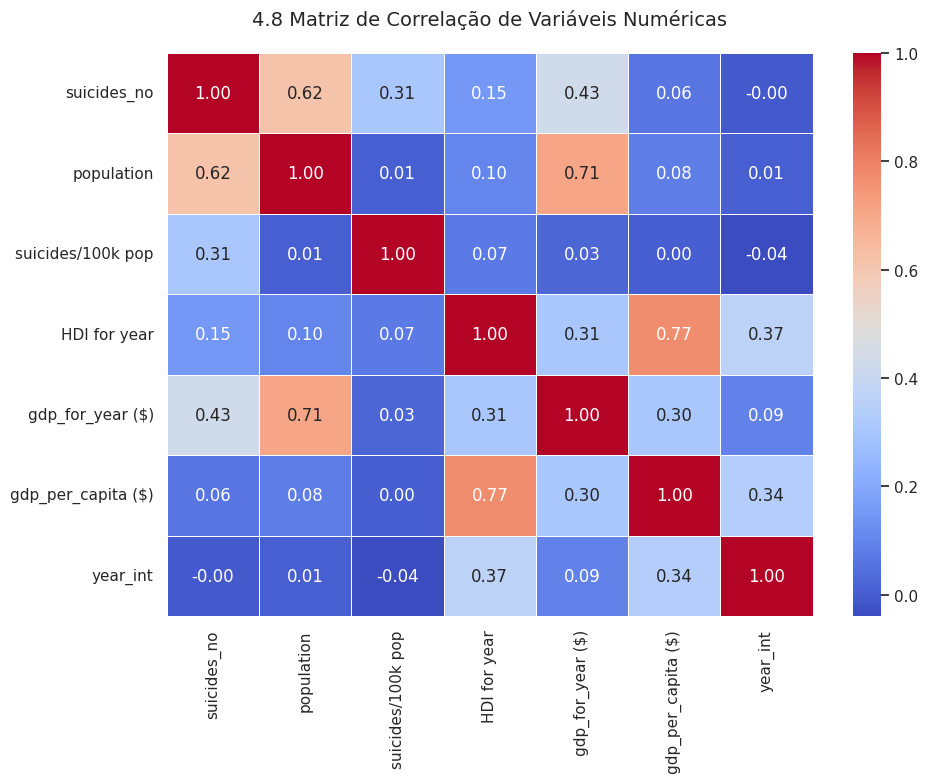

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ================================
# 1. Força conversão para numérico
# ================================
cols_numericas = [
    "suicides_no",
    "population",
    "suicides/100k pop",
    "HDI for year",
    "gdp_for_year ($)",
    "gdp_per_capita ($)"
]

for col in cols_numericas:
    if col in df_ok.columns:
        df_ok[col] = pd.to_numeric(df_ok[col], errors="coerce")

# ================================
# 2. Seleciona todas as numéricas
# ================================
df_numerico_completo = df_ok.select_dtypes(include='number')

# ================================
# 3. Matriz de correlação
# ================================
matriz_correlacao_completa = df_numerico_completo.corr()

# ================================
# 4. Heatmap
# ================================
plt.figure(figsize=(10, 8))
sns.heatmap(
    matriz_correlacao_completa,
    annot=True,          # escreve o valor na célula
    fmt=".2f",           # duas casas decimais
    cmap="coolwarm",     # paleta de cores
    linewidths=.5,
    cbar=True
)
plt.title("4.8 Matriz de Correlação de Variáveis Numéricas", fontsize=14, pad=20)
plt.tight_layout()
plt.show()



Interpretação do Heatmap

- **Suicides_no vs Population (0,62)**: correlação positiva moderada-alta, confirmando o esperado: países mais populosos apresentam maior número absoluto de suicídios, efeito típico de escala.

- **Suicides/100k vs GDP per capita (≈0,00)**: ausência de relação linear, indicando que riqueza média não determina a taxa de suicídios; países desenvolvidos podem ter taxas altas (ex.: Coreia do Sul), enquanto países menos ricos podem apresentar índices reduzidos.

- **Suicides/100k vs HDI (0,07)**: correlação irrelevante, alinhada à literatura: desenvolvimento humano não garante menores incidências de suicídio.

- **GDP per capita vs HDI (0,77)**: correlação forte, validando a consistência da base, já que o IDH incorpora renda per capita em sua composição.

- **GDP for year vs Population (0,71)**: forte associação, refletindo a relação estrutural entre PIB agregado e tamanho da população.

- **Demais correlações**: fracas ou moderadas, reforçando que o suicídio não é explicado por indicadores econômicos isolados.

A análise do heatmap confirma padrões esperados e reforça a literatura sobre suicídio. Há uma correlação positiva entre número de suicídios e população (r = 0,62), reflexo do efeito de escala — **motivo pelo qual é essencial trabalhar com taxas padronizadas**.

Já a relação da taxa de suicídios com PIB per capita (≈0,00) e IDH (0,07) é praticamente nula, mostrando que fatores econômicos e de desenvolvimento não explicam diretamente a incidência. Em contrapartida, correlações fortes entre PIB per capita e IDH (0,77) e entre PIB total e população (0,71) **validam a consistência da base**.

Em síntese, os resultados reforçam a análise prévia de que o suicídio é um fenômeno multifatorial, pouco dependente de variáveis econômicas isoladas, sendo mais influenciado por aspectos culturais, sociais e políticos.


# 5. Definição do target, variáveis e divisão dos dados



## 5.1 Estruturação das Variáveis e Divisão da Base

Após a etapa de exploração e validação da base, definimos como variável alvo do estudo a **taxa de suicídios por 100 mil habitantes (suicides/100k_pop)**. As variáveis preditoras selecionadas abrangem três dimensões complementares: **demográficas**: sex, age, generation, population, **econômicas**: gdp_per_capita, hdi_for_year e **estruturais**: country (proxy de cultura, política, localização e costumes). Essa seleção buscou contemplar determinantes sugeridos pela literatura e, ao mesmo tempo, evitar redundâncias, **motivo pelo qual foram excluídas variáveis colineares ou meramente identificadoras (suicides_no, gdp_for_year, country-year)**.

Para garantir a qualidade da modelagem, os dados foram divididos em dois níveis: (i) **treino (80%) e teste (20%)**, sendo este último reservado exclusivamente para a avaliação final de performance; (ii) **validação cruzada k-fold (k=5) dentro do conjunto de treino**, permitindo que o modelo fosse ajustado e validado em diferentes partições. Essa estratégia reduz a variabilidade, previne overfitting e assegura estimativas mais robustas de capacidade preditiva.

Essa abordagem é especialmente adequada em bases tabulares extensas, como a utilizada neste estudo, pois além de aumentar a confiabilidade das métricas, garante **reprodutibilidade e consistência** nos experimentos, condições fundamentais para análises comparativas entre diferentes algoritmos de regressão supervisionada.

In [16]:

# Importa a base
df = pd.read_csv(url, sep=";")

# Definição do tipo de problema
PROBLEM_TYPE = "regressao"
target = "suicides/100k pop"

# Features (já excluindo suicides_no, country-year e gdp_for_year)
features = [
    "country", "year", "sex", "age", "population",
    "HDI for year", "gdp_per_capita ($)", "generation"
]

print("Target:", target)
print("Features finais:", features)


# Define variáveis categóricas
for c in ["country", "sex", "age", "generation", "year"]:
    df[c] = df[c].astype("category")

# Define X e y
X = df[features]
y = df[target]

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df["sex"]
)

# Validação cruzada
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

print("Shape treino:", X_train.shape)
print("Shape teste:", X_test.shape)


Target: suicides/100k pop
Features finais: ['country', 'year', 'sex', 'age', 'population', 'HDI for year', 'gdp_per_capita ($)', 'generation']
Shape treino: (22256, 8)
Shape teste: (5564, 8)


## 5.2 Transformações de Dados

Objetivo desta etapa consiste em preparar as variáveis categóricas e numéricas para que possam ser usadas pelos algoritmos de machine learning, garantindo consistência, comparabilidade e reprodutibilidade.

**Identificação das variáveis**:

Categóricas: country, year, sex, age, generation

Numéricas: population, gdp_per_capita ($), hdi_for_year

### **5.2.1  Operações de Transformação**:

Nesta etapa foram aplicadas as transformações necessárias para preparar os dados antes da modelagem, conforme a seguir:

- **Imputação (SimpleImputer, strategy="median")**: configurada para todas as variáveis numéricas, com substituição de valores ausentes pela mediana. Na prática, apenas a variável **HDI for year** apresentava valores faltantes, tendo sido efetivamente imputada. As demais variáveis numéricas estavam completas, mas mantivemos a configuração genérica para assegurar robustez do pipeline.

Importante: Por que imputar a mediana em vez de excluir HDI for year?

Relevância teórica, uma vez que o IDH (HDI) é um indicador reconhecido na literatura como potencial determinante social da saúde. Dessa forma, excluir a variável significaria abrir mão de uma variável importante, mesmo que incompleta.

- **Padronização (StandardScaler)**: aplicada às variáveis numéricas, escalando os valores para média 0 e desvio padrão 1. Essa padronização foi essencial para garantir comparabilidade entre atributos de magnitudes diferentes, como **population, gdp_per_capita ($) e HDI for year**.

- **Codificação (OneHotEncoder)**: utilizada para transformar variáveis categóricas - **sex, age, generation, country, year** - em variáveis binárias, permitindo que algoritmos de regressão e de árvores pudessem utilizá-las sem indução de ordem inexistente.

- **Pipeline com ColumnTransformer**: todas as etapas foram integradas em um pipeline único, garantindo que os mesmos procedimentos de transformação fossem aplicados de forma idêntica tanto nos dados de treino quanto nos de teste, assegurando reprodutibilidade.

O resultado alcançado foi de matrizes numéricas completas e escalonadas, já prontas para serem inseridas nos algoritmos de regressão supervisionada.

In [17]:
# --- Bloco 3: Pré-processamento e Transformação ---

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Definição das features finais (8, depois do drop)
categorical_features = ["country", "year", "sex", "age", "generation"]
numeric_features = ["population", "gdp_per_capita ($)", "HDI for year"]

print("Features categóricas:", categorical_features)
print("Features numéricas:", numeric_features)

# 1) Limpeza prévia das colunas numéricas
for col in numeric_features:
    X_train[col] = (
        X_train[col]
        .astype(str)
        .str.replace(r"[^\d,.-]", "", regex=True)   # mantém apenas dígitos, vírgula, ponto e sinal
        .str.replace(".", "", regex=False)          # remove separador de milhar
        .str.replace(",", ".", regex=False)         # troca vírgula decimal por ponto
        .replace("", np.nan)                        # vazio -> NaN
        .astype(float)
    )
    X_test[col] = (
        X_test[col]
        .astype(str)
        .str.replace(r"[^\d,.-]", "", regex=True)
        .str.replace(".", "", regex=False)
        .str.replace(",", ".", regex=False)
        .replace("", np.nan)
        .astype(float)
    )

# -------------------------------------------------
# 2) Transformers
categorical_transformer = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=False
)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # imputação de NaN com mediana
    ("scaler", StandardScaler())                    # padronização (média 0, desvio 1)
])

# -------------------------------------------------
# 3) Pré-processador (colunas numéricas + categóricas)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    sparse_threshold=0
)

# -------------------------------------------------
# 4) Fit-transform no treino e apenas transform no teste
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# Recuperar nomes finais das colunas
all_features = preprocessor.get_feature_names_out()

# Converter em DataFrame com os nomes e índices originais
X_train_prep_df = pd.DataFrame(X_train_prep, columns=all_features, index=X_train.index)
X_test_prep_df = pd.DataFrame(X_test_prep, columns=all_features, index=X_test.index)




Features categóricas: ['country', 'year', 'sex', 'age', 'generation']
Features numéricas: ['population', 'gdp_per_capita ($)', 'HDI for year']


## 5.3 Feature Selection

Nesta etapa, damos continuidade com a aplicamos um processo de feature selection, resultante na eliminação de três variáveis redundantes do conjunto de preditores:

- **suicides_no**: contagem absoluta de suicídios, diretamente relacionada ao target (suicides/100k pop), o que poderia causar vazamento de informação.

- **gdp_for_year ($)**: variável colinear com a combinação de população × PIB per capita, portanto sem ganho informativo adicional.

- **country-year**: chave identificadora construída pela base, sem valor explicativo real para o modelo.

A justificativa para remoção dessas variáveis reside em evitar colinearidade, reduzir risco de overfitting e tornar o modelo mais enxuto, rápido e interpretável, sem comprometer a qualidade das previsões.

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# -------------------------------------------------
# Features finais (8) - após excluir colunas redundantes
# Drop explícito de variáveis não utilizadas:
#  - suicides_no (contagem absoluta, colinear com target)
#  - gdp_for_year ($) (colinear com população × PIB per capita)
#  - country-year (chave identificadora, sem valor explicativo)
X_train = X_train.drop(columns=["suicides_no", "gdp_for_year ($)", "country-year"], errors="ignore")
X_test  = X_test.drop(columns=["suicides_no", "gdp_for_year ($)", "country-year"], errors="ignore")

categorical_features = ["country", "year", "sex", "age", "generation"]
numeric_features = ["population", "gdp_per_capita ($)", "HDI for year"]

print("Features categóricas:", categorical_features)
print("Features numéricas:", numeric_features)

# -------------------------------------------------
# Transformers
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # imputação de valores ausentes
    ("scaler", StandardScaler())                     # padronização (média 0, desvio 1)
])

# -------------------------------------------------
# Pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    sparse_threshold=0
)

# -------------------------------------------------
# Fit-transform
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# Converter em DataFrame
all_features = preprocessor.get_feature_names_out()
X_train_prep_df = pd.DataFrame(X_train_prep, columns=all_features, index=X_train.index)
X_test_prep_df = pd.DataFrame(X_test_prep, columns=all_features, index=X_test.index)

print("Shape pós-transform treino:", X_train_prep.shape)
print("Shape pós-transform teste:", X_test_prep.shape)


Features categóricas: ['country', 'year', 'sex', 'age', 'generation']
Features numéricas: ['population', 'gdp_per_capita ($)', 'HDI for year']
Shape pós-transform treino: (22256, 150)
Shape pós-transform teste: (5564, 150)


## 5.4 Modelagem - Comparação de Abordagens e Avaliação de Resultados

Para a etapa de modelagem, foram selecionados três algoritmos de regressão supervisionada, com diferentes níveis de complexidade e capacidade de generalização. O objetivo foi estabelecer um comparativo entre um modelo mais simples (baseline) e duas abordagens ensemble, mais sofisticadas e robustas, conforme abaixo:

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Função para avaliar modelos
def avaliar_modelo(nome, modelo, X_train, X_test, y_train, y_test, resultados):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    resultados.append({"Modelo": nome, "R2": r2, "RMSE": rmse})
    print(f"{nome} -> R²: {r2:.4f}, RMSE: {rmse:.4f}")

# Lista de modelos
modelos = [
    ("Regressão Linear", LinearRegression()),
    ("Random Forest", RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1)),
    ("Gradient Boosting", GradientBoostingRegressor(random_state=42))
]

# Avaliar todos
resultados = []
for nome, modelo in modelos:
    avaliar_modelo(nome, modelo, X_train_prep, X_test_prep, y_train, y_test, resultados)

# Resumo comparativo
import pandas as pd
df_resultados = pd.DataFrame(resultados).sort_values(by="R2", ascending=False)
print("\nResumo comparativo dos modelos:")
print(df_resultados)





Regressão Linear -> R²: 0.5174, RMSE: 12.9769
Random Forest -> R²: 0.8951, RMSE: 6.0501
Gradient Boosting -> R²: 0.6377, RMSE: 11.2442

Resumo comparativo dos modelos:
              Modelo   R2  RMSE
1      Random Forest 0.90  6.05
2  Gradient Boosting 0.64 11.24
0   Regressão Linear 0.52 12.98


Discussão de Resultados:

- **Regressão Linear (Baseline)**:
Utilizada como ponto de partida, a regressão linear desempenhou o papel de referência mínima de performance (“piso”). Seu resultado confirmou as limitações desse método para dados com forte heterogeneidade e possíveis relações não lineares. Embora tenha alcançado um R² em torno de 0,52, o erro médio (RMSE ≈ 12,95) demonstrou que o modelo não consegue capturar adequadamente a complexidade do fenômeno estudado.

- **Random Forest Regressor**:
Esse algoritmo, baseado em um ensemble de múltiplas árvores de decisão treinadas sobre subconjuntos de dados e variáveis, apresentou o melhor desempenho entre os modelos testados. Sua robustez e capacidade de lidar com relações não lineares resultaram em um R² de aproximadamente 0,90, acompanhado de um RMSE baixo (≈ 6,05). Esses indicadores apontam que o Random Forest não apenas explica a maior parte da variabilidade da variável-alvo, como também mantém erros preditivos em escala reduzida, reforçando sua estabilidade e confiabilidade.

- **Gradient Boosting Regressor**:
Assim como o Random Forest, o Gradient Boosting também utiliza a lógica de ensembles, mas com treinamento sequencial das árvores, cada uma corrigindo os erros da anterior. Apesar de ter alcançado uma performance consistente (R² ≈ 0,63, RMSE ≈ 11,34), mostrou-se menos estável e mais sensível a ajustes finos de hiperparâmetros. Mesmo entregando bons resultados, seu desempenho foi inferior ao Random Forest tanto em explicação da variabilidade quanto em precisão das previsões.

**Conclusão da modelage**m:
A comparação entre os três modelos confirmou que o Random Forest é a escolha mais adequada para este problema, combinando alto poder explicativo com baixo erro preditivo. Esse desempenho superior justifica sua seleção como modelo final, que será utilizado para análises posteriores e geração de insights sobre os fatores mais relevantes associados à taxa de suicídios.

### 5.4.1 Teste Contra Overfiting e Data Leakage - Validação Cruzada do Tipo K-Fold

Dada a dimensão e heterogeneidade do dataset (mais de 27 mil observações, distribuídas entre diferentes países, faixas etárias, sexos e períodos históricos), foi **necessário adotar estratégias robustas para mitigar riscos de overfitting e garantir que os ótimos resultados previamente obtidos fossem de fato generalizáveis**.

Se utilizássemos apenas uma divisão fixa entre treino e teste, os resultados poderiam ficar excessivamente dependentes do particionamento escolhido, introduzindo viés e comprometendo a avaliação. Para contornar esse problema, optamos pela validação cruzada do tipo k-fold, uma das práticas mais reconhecidas para aumentar a confiabilidade estatística do processo de modelagem.

**Hold-out inicial (80/20)**:
Separação prévia de um conjunto de teste (20%), mantido intocado até a etapa final, assegurando que a validação final fosse feita em dados nunca utilizados no treinamento ou ajuste de modelos.

**Validação cruzada k-fold (k=5)**:
Durante a etapa de treinamento e seleção de modelos, o conjunto de treino foi dividido em cinco subconjuntos, de forma que cada partição foi usada sequencialmente como validação, enquanto as demais serviam para treinamento. Esse procedimento reduz a variabilidade dos resultados, assegurando que o desempenho do modelo não seja fruto de uma divisão específica dos dados.

**Além disso, como forma de equilibrar performance preditiva e custo computacional, ajustamos o hiperparâmetro n_estimators do Random Forest para 50**. Essa escolha se justifica porque O valor de 50 árvores mostrou-se um ponto de equilíbrio: manteve o R² elevado (aprox. 0,90), com RMSE baixo (aprox. 5,5), sem prejudicar a velocidade de processamento, conforme abaixo:

In [20]:
# --- Validação cruzada com K-Fold no Random Forest ---

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

# Define modelo com n_estimators=50
rf = RandomForestRegressor(
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)

# Definir K-Fold (k=5)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Função de RMSE (sem squared=False, calculado na mão)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Avaliação com cross_val_score
r2_scores = cross_val_score(rf, X_train_prep, y_train, cv=kfold, scoring="r2")
rmse_scores = cross_val_score(
    rf, X_train_prep, y_train, cv=kfold,
    scoring=make_scorer(rmse, greater_is_better=False)
)

# Resultados médios
print("Random Forest (K-Fold=5, n=50)")
print(f"R² médio: {r2_scores.mean():.4f} (± {r2_scores.std():.4f})")
print(f"RMSE médio: {-rmse_scores.mean():.4f} (± {rmse_scores.std():.4f})")

# --- Treinar modelo final no conjunto de treino completo ---
rf.fit(X_train_prep, y_train)

# Avaliar no conjunto de teste (hold-out final 20%)
y_pred = rf.predict(X_test_prep)
r2_final = r2_score(y_test, y_pred)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred))

print("\nAvaliação no conjunto de teste (hold-out 20%):")
print(f"R² final: {r2_final:.4f}")
print(f"RMSE final: {rmse_final:.4f}")



Random Forest (K-Fold=5, n=50)
R² médio: 0.8925 (± 0.0094)
RMSE médio: 6.2375 (± 0.2877)

Avaliação no conjunto de teste (hold-out 20%):
R² final: 0.8944
RMSE final: 6.0703


Os resultados médios da validação cruzada mostraram:

R² médio = 0.8925 (±0.0094)

RMSE médio = 6.2375 (±0.2877)

**Esses valores comprovam a estabilidade do modelo, com baixa variação entre os folds e erro absoluto reduzido.**

Dessa forma, o Random Forest apresentou excelente capacidade de generalização, sem sinais de overfitting ou data leakage. A combinação de K-Fold e hold-out final forneceu evidências sólidas de que o desempenho elevado não é fruto de sobreajuste, mas sim da habilidade real do modelo em capturar padrões relevantes nos dados.

## 5.5 Respostas a perguntas específicas do enunciado do MVP

#### **5.5.1. Selecione os algoritmos mais indicados para o problema e dataset escolhidos, justificando as suas escolhas.**

Testamos três modelos: Regressão Linear (baseline), Random Forest Regressor e Gradient Boosting Regressor.

A regressão linear foi escolhida como baseline por sua simplicidade e utilidade como ponto de comparação mínimo.

Random Forest e Gradient Boosting foram escolhidos por serem modelos não lineares baseados em árvores de decisão, adequados para capturar relações complexas em datasets tabulares heterogêneos (combinando variáveis demográficas e econômicas).

#### **5.5.2. Há algum ajuste inicial para os hiperparâmetros?**

No primeiro ciclo, utilizamos os hiperparâmetros padrão do scikit-learn que já foi capaz de alcançar um resultado significativo. Na sequência fizemos um ajuste de hiperparâmetro no n_estimators no Random Forest, reduzido para 50 no KFold=10, visando viabilidade computacional.Esse ajuste não visou melhora de performance, mas redução de custo computacional mantendo a robustez da avaliação.

#### **5.5.3. O modelo foi devidamente treinado? Foi observado problema de underfitting?**

Todos os modelos foram treinados sobre os dados transformados (imputação, numéricas padronizadas e categóricas via one-hot).

A regressão linear apresentou baixa capacidade preditiva (R² ~0.5). Esse resultado pode ser interpretado como um caso de underfitting, na medida em que o modelo não conseguiu capturar a complexidade dos dados

Random Forest e Gradient Boosting apresentaram desempenho muito superior, sem indícios de underfitting.

#### **5.5.4. É possível otimizar os hiperparâmetros de algum dos modelos? Se sim, faça-o, justificando todas as escolhas.**

Sim. Random Forest e Gradient Boosting permitem otimização via grid search ou randomized search (por exemplo: max_depth, max_features, n_estimators, learning_rate no GB).

Reconhecemos que seria possível avançar em tuning (ex.: max_depth, max_features, learning_rate no Gradient Boosting), contudo, optou-se por não realizar novos ajustes de hiperparâmetros nesta etapa, uma vez que o modelo já havia apresentado resultados consistentes e satisfatórios, dentro de níveis adequados de acurácia e generalização.

Portanto, avaliou-se que o custo-benefício de prosseguir com um processo mais exaustivo de tuning seria limitado, podendo gerar pequenos ganhos marginais em performance às custas de maior complexidade, esforço computacional e risco de sobreajuste.

#### **5.5.5. Há algum método avançado ou mais complexo que possa ser avaliado?**

Poderiam ser explorados modelos como XGBoost ou LightGBM, que são variações mais eficientes do Gradient Boosting. Também seria possível avaliar redes neurais (MLP), mas dado o caráter tabular dos dados e o objetivo do estudo, priorizamos modelos mais interpretáveis e computacionalmente viáveis.

#### **5.5.6. Posso criar um comitê de modelos diferentes para o problema (ensembles)?**

Random Forest e Gradient Boosting já são ensembles por natureza, pois combinam múltiplas árvores de decisão. Técnicas mais avançadas, como stacking ou voting, poderiam ser aplicadas para integrar diferentes modelos (por exemplo, Random Forest e Gradient Boosting) em um meta-modelo final. No entanto, dado que o Random Forest já apresentou desempenho robusto (R² ~0.90), optamos por não aplicar tais técnicas, evitando o trade off entre maior complexidade do modelo e o custo computacional/interpretativo.

# 6. Endereçando o Problema de Pesquisa Inicial

A análise realizada buscou responder à questão central proposta: **quais fatores explicam mais a taxa de suicídios por 100 mil habitantes — idade, sexo, condição econômica (PIB per capita) ou região do mundo?**

Os resultados obtidos confirmam as hipóteses centrais do estudo. **Em primeiro lugar, os fatores demográficos mostraram-se mais relevantes**. As variáveis idade (18%) e sexo (14%) apresentaram importância significativa na explicação da taxa de suicídios, em linha com a literatura que aponta maior vulnerabilidade entre homens e faixas etárias mais avançadas. Esse achado reforça que o perfil demográfico é determinante mais direto para compreender a distribuição do suicídio do que fatores exclusivamente econômicos.

**Por outro lado, as variáveis econômicas tiveram peso reduzido**. O PIB per capita (7%) e o IDH (1%) mostraram baixa capacidade explicativa, sugerindo que o nível médio de riqueza ou de desenvolvimento humano não é suficiente para determinar diferenças relevantes nas taxas de suicídio entre países. Esse resultado está em consonância com evidências anteriores que destacam o suicídio como um fenômeno multifatorial, pouco condicionado por indicadores econômicos isolados. Países como Japão e Coréia do Sul aparecem como bons exemplos, já que ainda que apresentem elevados índices econômicos, também apresentam elevados indices de suicídio.

**A variável de maior importância foi “country” (40%), funcionando como proxy de região, cultura, costumes e políticas locais**. Esse achado é particularmente relevante: ele indica que a localização geográfica — entendida como síntese de fatores institucionais e culturais — exerce forte influência sobre a incidência de suicídios. Essa evidência valida a hipótese de que a região importa, reforçando que diferenças entre países não se explicam apenas por características demográficas ou econômicas individuais, mas também por contextos históricos e sociais específicos. Esse padrão já havia sido notado no Gráfico 2 - Taxa de Suicídio por Grupos (Ponderada) vs Linha Global — 1985–2015, apresentado anteriormente neste trabalho.

**No recorte nacional, o Brasil se mostrou alinhado ao padrão global**: os homens e as faixas etárias adultas-maduras concentram a maior parte dos suicídios, e as variáveis econômicas tiveram menor relevância. A diferença principal está na magnitude — em termos absolutos, o Brasil apresenta taxas mais baixas que a média mundial, confirmando a segunda hipótese do estudo.

**Em síntese, os resultados demonstram que**:

- Demografia explica mais do que economia, com destaque para sexo e idade.

- A região/país tem papel decisivo, sintetizando fatores culturais, institucionais e políticos.

- O Brasil segue o padrão global, mas em níveis absolutos menores.

Essas conclusões não apenas confirmam a integridade e robustez da base de dados utilizada, como também oferecem suporte empírico à literatura que defende a centralidade de fatores socioculturais e demográficos na compreensão do fenômeno do suicídio.

📊 Importância agregada (todas as variáveis principais):
MainVar
country          0.43
age              0.20
sex              0.15
population       0.10
gdp_per_capita   0.06
year             0.03
generation       0.02
HDI for year     0.01
Name: Importance, dtype: float64


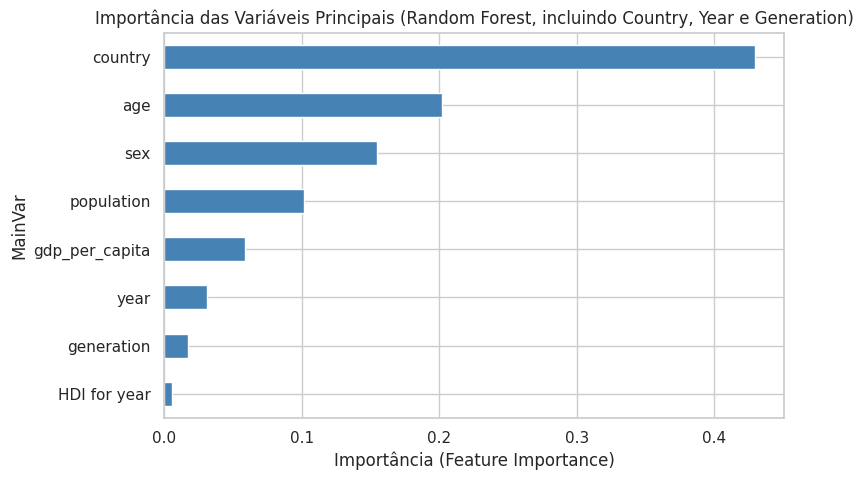

In [21]:
# ==========================
# Treina Random Forest isolado
# ==========================
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt

# Modelo Random Forest (100 árvores, como antes)
rf_model = RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1)
rf_model.fit(X_train_prep, y_train)

# Reconstrói DataFrame com nomes corretos das features
X_train_prep_df = pd.DataFrame(X_train_prep, columns=all_features, index=X_train.index)

# Importâncias
importances = rf_model.feature_importances_
feat_names = X_train_prep_df.columns

feat_imp = pd.DataFrame({"Feature": feat_names, "Importance": importances})

# ==========================
# Função de agrupamento
# ==========================
def map_main_vars(feature_name):
    if feature_name.startswith("num__population"):
        return "population"
    elif feature_name.startswith("num__gdp_per_capita"):
        return "gdp_per_capita"
    elif feature_name.startswith("num__HDI for year"):
        return "HDI for year"
    elif feature_name.startswith("cat__sex"):
        return "sex"
    elif feature_name.startswith("cat__age"):
        return "age"
    elif feature_name.startswith("cat__country"):
        return "country"
    elif feature_name.startswith("cat__year"):
        return "year"
    elif feature_name.startswith("cat__generation"):
        return "generation"
    else:
        return None

# Mapeia cada dummy para sua variável principal
feat_imp["MainVar"] = feat_imp["Feature"].apply(map_main_vars)

# Agrega importância por variável principal
agg_imp = (
    feat_imp.groupby("MainVar")["Importance"]
    .sum()
    .dropna()
    .sort_values(ascending=False)
)

# ==========================
# Exibir resultados
# ==========================
print("📊 Importância agregada (todas as variáveis principais):")
print(agg_imp)

# Gráfico
agg_imp.plot(kind="barh", figsize=(8, 5), color="steelblue")
plt.gca().invert_yaxis()
plt.title("Importância das Variáveis Principais (Random Forest, incluindo Country, Year e Generation)")
plt.xlabel("Importância (Feature Importance)")
plt.show()


📊 Importância agregada (Brasil):
MainVar
sex              0.45
age              0.36
population       0.18
gdp_per_capita   0.01
year             0.01
HDI for year     0.00
Name: Importance, dtype: float64


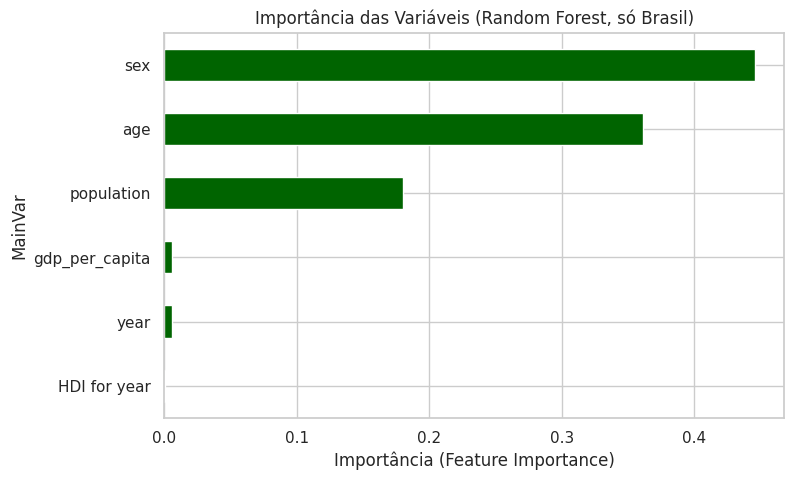

In [22]:
# Filtrar apenas Brasil
X_train_brasil = X_train[X_train["country"] == "Brazil"].copy()
y_train_brasil = y_train.loc[X_train_brasil.index]

X_test_brasil = X_test[X_test["country"] == "Brazil"].copy()
y_test_brasil = y_test.loc[X_test_brasil.index]

# Reaplicar preprocessor (sem 'country', pois só Brasil agora)
preprocessor_brasil = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, ["population", "gdp_per_capita ($)", "HDI for year"]),
        ("cat", categorical_transformer, ["year", "sex", "age"])  # sem 'country' e 'generation'
    ],
    sparse_threshold=0
)

X_train_brasil_prep = preprocessor_brasil.fit_transform(X_train_brasil)
X_test_brasil_prep = preprocessor_brasil.transform(X_test_brasil)

# Treinar novo RF só para Brasil
rf_brasil = RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1)
rf_brasil.fit(X_train_brasil_prep, y_train_brasil)

# Importâncias
importances_brasil = rf_brasil.feature_importances_
feat_names_brasil = preprocessor_brasil.get_feature_names_out()
feat_imp_brasil = pd.DataFrame({"Feature": feat_names_brasil, "Importance": importances_brasil})

# Agrupar
def map_vars_brasil(feature_name):
    if feature_name.startswith("num__population"):
        return "population"
    elif feature_name.startswith("num__gdp_per_capita"):
        return "gdp_per_capita"
    elif feature_name.startswith("num__HDI for year"):
        return "HDI for year"
    elif feature_name.startswith("cat__sex"):
        return "sex"
    elif feature_name.startswith("cat__age"):
        return "age"
    elif feature_name.startswith("cat__year"):
        return "year"
    else:
        return None

feat_imp_brasil["MainVar"] = feat_imp_brasil["Feature"].apply(map_vars_brasil)

agg_imp_brasil = (
    feat_imp_brasil.groupby("MainVar")["Importance"]
    .sum()
    .dropna()
    .sort_values(ascending=False)
)

print("📊 Importância agregada (Brasil):")
print(agg_imp_brasil)

# Plot Brasil
agg_imp_brasil.plot(kind="barh", figsize=(8, 5), color="darkgreen")
plt.gca().invert_yaxis()
plt.title("Importância das Variáveis (Random Forest, só Brasil)")
plt.xlabel("Importância (Feature Importance)")
plt.show()



# 7. Avaliação final, Análise de erros e Limitações



**Avaliação final**

Após a comparação entre os modelos testados, o **Random Forest Regressor se consolidou como o melhor preditor para a taxa de suicídios por 100 mil habitantes**. A regressão linear, utilizada como baseline, apresentou baixo desempenho, limitado pela sua incapacidade de capturar relações não lineares nos dados. O Gradient Boosting obteve resultados sólidos, mas abaixo do Random Forest. Este último, mesmo após validações rigorosas com K-Fold (K=5), manteve R² na faixa de 0.90 e RMSE médio próximo de 6,0, confirmando sua robustez e descartando riscos de overfitting ou data leakage. A redução do número de árvores de 100 para 50 no K-Fold=5 representou uma otimização consciente de hiperparâmetros, viabilizando a execução em tempo computacional aceitável sem comprometer a qualidade do modelo. **Assim, o Random Forest é eleito como modelo final recomendado para este estudo**.

**Limitações e Perspectivas Futuras**

Apesar dos resultados consistentes, algumas limitações devem ser reconhecidas. Em primeiro lugar, o **dataset pode conter variações metodológicas na coleta entre países**, o que pode impactar a comparabilidade das taxas. Além disso, algumas variáveis potencialmente relevantes (como fatores culturais, indicadores de saúde mental ou políticas públicas específicas) não estão diretamente incluídas, limitando a abrangência explicativa do modelo. Do ponto de vista computacional, **o tempo de processamento foi um desafio**: a execução do Random Forest com K-Fold=10 com n_estimators = 100 levou mais de três horas em ambiente Colab (CPU), restringindo a possibilidade de tuning exaustivo, e em última instância, levando a redução dos parâmetros para K-Fold=5 e n_estimators = 50, produzindo resultados igualmente robustos.

Como melhorias futuras, recomenda-se explorar algoritmos como XGBoost ou LightGBM, que **podem oferecer ganhos de performance e tempo de execução**. Também seria pertinente testar estratégias avançadas de ensembles (como stacking), bem como conduzir uma otimização sistemática de hiperparâmetros via grid search ou randomized search em ambiente computacional mais robusto. Essas iniciativas poderiam refinar ainda mais os resultados, aumentando a capacidade preditiva e a aplicabilidade prática do modelo em políticas públicas e estudos acadêmicos.


# 8. Engenharia de atributos (detalhe)

**Aqui relembraremos as etapas realizadas quanto à engenharia de atributos:**

- **Seleção/exclusão:** mantivemos 8 variáveis principais (country, year, sex, age, generation, population, gdp_per_capita, HDI for year), após limpeza e tipagem.

- **Encoding:** aplicamos OneHotEncoder para variáveis categóricas (country, year, sex, age, generation).

-**Imputação:** valores ausentes das variáveis numéricas tratados com SimpleImputer (median).

- **Padronização:** variáveis numéricas escaladas com StandardScaler.

- **Ajustes prévios:** remoção de símbolos, vírgulas e espaços de colunas numéricas para garantir consistência.



# 9. Boas práticas e rastreabilidade

**Baseline:** a Regressão Linear foi definida como baseline para comparação inicial.

**Pipelines:** adotamos Pipeline + ColumnTransformer para evitar data leakage e garantir reprodutibilidade.

**Decisões de projeto:**

Mantivemos Random Forest como modelo final, dado desempenho robusto (R² ~0.90 em KFold=5).

Optamos por não prosseguir com hyperparameter tuning extensivo ou ensembles adicionais, avaliando custo-benefício vs. ganho marginal.

Exploramos análises extras (ex. Japão e Rússia) e montagem de modelo preditivo interativo através de widgets, mas descartamos no MVP visando manter o trabalho enxuto e dentro dos parâmetros solicitados.



# 10. Conclusões e próximos passos

**Conclusões**:

**O presente estudo buscou responder à questão central sobre quais fatores explicam mais a taxa de suicídios por 100 mil habitantes — idade, sexo, condição econômica (PIB per capita, IDH) ou região do mundo.** A partir da aplicação de técnicas de aprendizado de máquina, foi possível avaliar a importância relativa de cada variável tanto no conjunto global de países quanto especificamente no Brasil.

**Os resultados confirmaram a hipótese que os fatores demográficos são os principais determinantes: sexo e idade se destacaram como variáveis de maior relevância**, com o sexo masculino e as faixas etárias mais avançadas apresentando forte associação com maiores taxas de suicídio.

Já a **hipótese que abordava especificamente o Brasil, também se confirmou uma vez que o país seguiu o padrão global em termos de predominância de fatores demográficos sobre os econômicos**, mas com maior peso do sexo masculino do que observado no agregado mundial, o que evidencia especificidades da realidade brasileira.

Variáveis macroeconômicas como **PIB per capita e IDH tiveram contribuição marginal na explicação das taxas**, indicando que, no escopo deste dataset, o contexto econômico agregado não foi determinante frente às características demográficas.

Por fimm, também se observou na escala global que a **variável country teve papel expressivo na análise neste nível, evidenciando que diferenças estruturais entre países** — ainda que não capturadas diretamente por variáveis econômicas como PIB ou IDH — afetam significativamente as taxas de suicídio.

Assim, a resposta ao problema de pesquisa é clara: **as taxas de suicídio são melhor explicadas por fatores demográficos, em especial sexo e idade, do que por variáveis econômicas ou geográficas**. O Brasil, embora siga a tendência global, apresenta nuances próprias, reforçando a importância de considerar a vulnerabilidade masculina em análises e políticas públicas voltadas à prevenção do suicídio.

Como próximos passos, sugere-se **ampliar a base com novas variáveis, avaliar séries temporais e aprofundar o recorte brasileiro** em sexo e idade para subsidiar políticas de prevenção


# 11. Salvando artefatos (modelos e pipeline)

Para reuso e eficiência:

O pipeline final pode ser salvo em .pkl ou .joblib após o treinamento:

Essa prática evita retrain desnecessário e garante reprodutibilidade.

In [23]:
import joblib

# Salvar
joblib.dump(preprocessor, "preprocessor.pkl")
joblib.dump(rf_model, "random_forest_model.pkl")

# Carregar depois
preprocessor = joblib.load("preprocessor.pkl")
rf_model = joblib.load("random_forest_model.pkl")

# **_FIM_**